# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [111]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [112]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


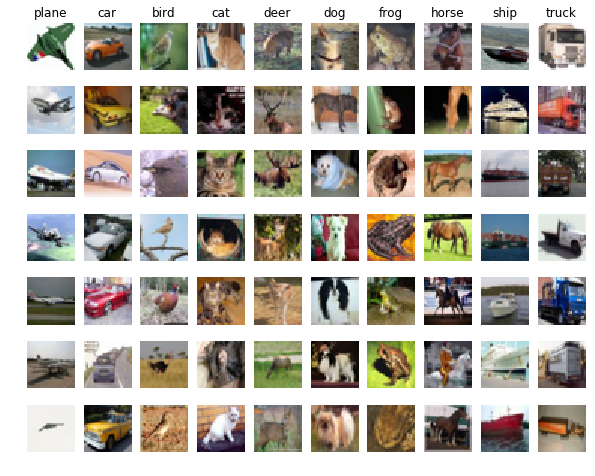

In [113]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [114]:
print (type(X_train))
len(X_train)
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
mask = range(num_training, num_training + num_validation)
len(X_train[mask])

<class 'numpy.ndarray'>


1000

In [115]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [116]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


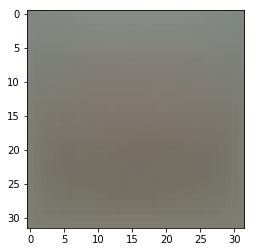

In [117]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [118]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [119]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [120]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.866021


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [121]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.095860 analytic: 2.095860, relative error: 9.209035e-11
numerical: -22.870332 analytic: -22.870332, relative error: 7.355579e-12
numerical: 3.763982 analytic: 3.763982, relative error: 3.392609e-11
numerical: -12.729208 analytic: -12.729208, relative error: 2.708896e-11
numerical: 8.551386 analytic: 8.551386, relative error: 6.793412e-12
numerical: -9.728022 analytic: -9.728022, relative error: 4.259284e-11
numerical: -3.846200 analytic: -3.846200, relative error: 2.335723e-11
numerical: 12.815534 analytic: 12.815534, relative error: 1.222849e-11
numerical: 22.350172 analytic: 22.344447, relative error: 1.281037e-04
numerical: 11.827558 analytic: 11.827558, relative error: 1.048687e-11
numerical: 5.646523 analytic: 5.697134, relative error: 4.461639e-03
numerical: -1.732578 analytic: -1.732578, relative error: 1.962888e-10
numerical: -4.583642 analytic: -4.595636, relative error: 1.306648e-03
numerical: 21.398736 analytic: 21.475787, relative error: 1.797125e-03
numerical:

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** Yes, it is possible that once in a while a dimension in the gradcheck will not match exactly.
That discrepancy is caused because some loss functions with kinks (ReLU) that are not differentiable at all the points. For example, hinge loss is not differentiable at 0. However, it is not a reason for concern since we take the value of h to be sufficiently small.

In [122]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.866021e+00 computed in 0.101553s
Vectorized loss: 8.866021e+00 computed in 0.017286s
difference: 0.000000


In [123]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.100871s
Vectorized loss and gradient: computed in 0.006435s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [124]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 776.654768
iteration 100 / 1500: loss 283.782006
iteration 200 / 1500: loss 106.932735
iteration 300 / 1500: loss 41.225114
iteration 400 / 1500: loss 18.703495
iteration 500 / 1500: loss 9.829248
iteration 600 / 1500: loss 7.319200
iteration 700 / 1500: loss 5.700635
iteration 800 / 1500: loss 5.845215
iteration 900 / 1500: loss 5.063825
iteration 1000 / 1500: loss 5.746189
iteration 1100 / 1500: loss 5.246945
iteration 1200 / 1500: loss 5.605423
iteration 1300 / 1500: loss 5.339783
iteration 1400 / 1500: loss 4.965863
That took 4.412923s


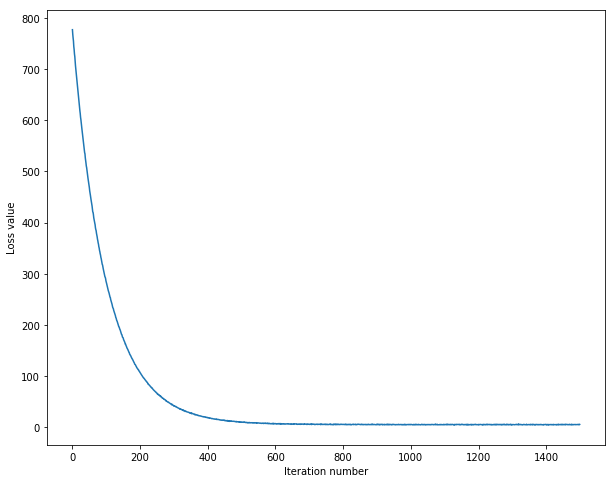

In [125]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [127]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.364245
validation accuracy: 0.364000


In [128]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]


learning_rates = [ 5e-8, 1e-7, 2e-7]
regularization_strengths = [  1e4,  1.25e4, 1.5e4, 1.75e4, 2e4]


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svms = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=5000, verbose = True)
        y_val_pred = svm.predict(X_val)
        y_train_pred = svm.predict(X_train)
        val_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train == y_train_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        svms[(lr, reg)] = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_svm = svms[(lr, reg)]
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 330.567776
iteration 100 / 5000: loss 262.446768
iteration 200 / 5000: loss 215.036079
iteration 300 / 5000: loss 175.200984
iteration 400 / 5000: loss 144.098503
iteration 500 / 5000: loss 117.741281
iteration 600 / 5000: loss 96.756405
iteration 700 / 5000: loss 79.791368
iteration 800 / 5000: loss 66.378434
iteration 900 / 5000: loss 55.183515
iteration 1000 / 5000: loss 45.805611
iteration 1100 / 5000: loss 38.165171
iteration 1200 / 5000: loss 31.919949
iteration 1300 / 5000: loss 26.783336
iteration 1400 / 5000: loss 22.851550
iteration 1500 / 5000: loss 19.815201
iteration 1600 / 5000: loss 17.179766
iteration 1700 / 5000: loss 14.464664
iteration 1800 / 5000: loss 13.192038
iteration 1900 / 5000: loss 11.439032
iteration 2000 / 5000: loss 10.150776
iteration 2100 / 5000: loss 9.205604
iteration 2200 / 5000: loss 8.261215
iteration 2300 / 5000: loss 7.870169
iteration 2400 / 5000: loss 7.389816
iteration 2500 / 5000: loss 7.386819
iteration 2600 / 5000: 

In [ ]:
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.384714 val accuracy: 0.393000


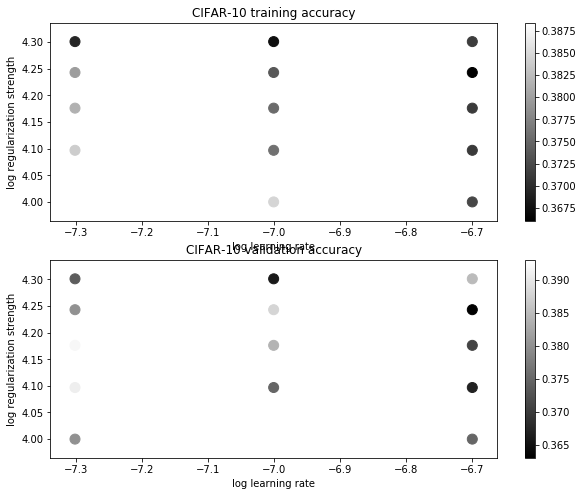

In [129]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [130]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.389000


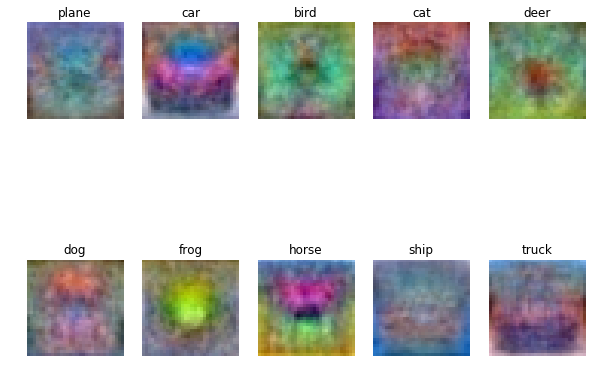

In [131]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** Few classes like car can be seen clearly. However, horse class appears to have two heads. Similarly, dog appears to have two heads too. This could be either because of multiple dogs in the picture or dogs and horses with different orientations in the picture. Similarly, we can see a lot of blue in the bottom for ship and blue at the top in the plane class. Deer class has lot of green grass in it. 



Effect of Regularization Strength: As shown below as a bonus, the SVM weights appear more like their objects when regularization constant is high! For reg = 0 and reg = 1e6, we have similar validation accuracy of 29%. However, weights are much better visualizable for higher regularization as model can achieve lower loss with a single large weight magnitude spread out to nearby weights.

In [132]:
#BONUS


learning_rates = [1e-7, 5e-5]

#learning_rates = [ 5e-8, 1e-7, 2e-7, 5e-7]
regularization_strengths = [ 0]
#regularization_strengths = [ 1e6]


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svms = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=2000, verbose = True)
        y_val_pred = svm.predict(X_val)
        y_train_pred = svm.predict(X_train)
        val_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train == y_train_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        svms[(lr, reg)] = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_svm_reg0 = svms[(lr, reg)]
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)


iteration 0 / 2000: loss 21.189037
iteration 100 / 2000: loss 10.477594
iteration 200 / 2000: loss 10.352351
iteration 300 / 2000: loss 8.321098
iteration 400 / 2000: loss 8.431268
iteration 500 / 2000: loss 8.468110
iteration 600 / 2000: loss 7.598401
iteration 700 / 2000: loss 7.882553
iteration 800 / 2000: loss 6.937743
iteration 900 / 2000: loss 7.017815
iteration 1000 / 2000: loss 6.548012
iteration 1100 / 2000: loss 7.444102
iteration 1200 / 2000: loss 6.571920
iteration 1300 / 2000: loss 7.141593
iteration 1400 / 2000: loss 5.191564
iteration 1500 / 2000: loss 6.022804
iteration 1600 / 2000: loss 6.787885
iteration 1700 / 2000: loss 6.030655
iteration 1800 / 2000: loss 5.901283
iteration 1900 / 2000: loss 6.216045
iteration 0 / 2000: loss 18.466639
iteration 100 / 2000: loss 136.167738
iteration 200 / 2000: loss 80.898675
iteration 300 / 2000: loss 122.477935
iteration 400 / 2000: loss 122.687617
iteration 500 / 2000: loss 122.819620
iteration 600 / 2000: loss 90.613938
iteratio

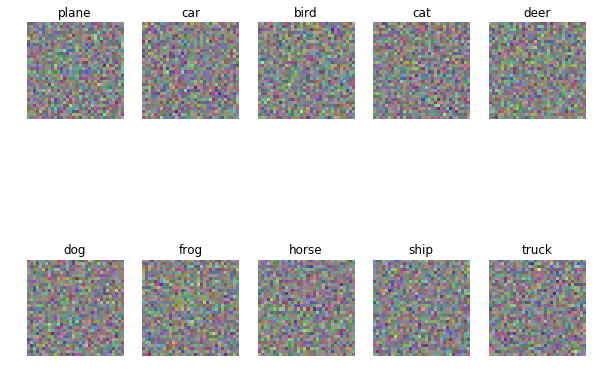

In [133]:
"""
regularization_strength = 0

"""

# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm_reg0.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [140]:
"""
Effect on pictures with much small but non zero regularization strength

"""

learning_rates = [1e-7, 5e-5]

#learning_rates = [ 5e-8, 1e-7, 2e-7, 5e-7]
#regularization_strengths = [ 0]
regularization_strengths = [ 1e4]


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svms = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=2000, verbose = True)
        y_val_pred = svm.predict(X_val)
        y_train_pred = svm.predict(X_train)
        val_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train == y_train_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        svms[(lr, reg)] = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_svm_regSmall = svms[(lr, reg)]
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 324.727260
iteration 100 / 2000: loss 214.025206
iteration 200 / 2000: loss 142.829908
iteration 300 / 2000: loss 96.535475
iteration 400 / 2000: loss 65.866597
iteration 500 / 2000: loss 46.131275
iteration 600 / 2000: loss 32.287481
iteration 700 / 2000: loss 23.295639
iteration 800 / 2000: loss 17.170447
iteration 900 / 2000: loss 12.546045
iteration 1000 / 2000: loss 10.397464
iteration 1100 / 2000: loss 8.362953
iteration 1200 / 2000: loss 7.829128
iteration 1300 / 2000: loss 7.014991
iteration 1400 / 2000: loss 6.277773
iteration 1500 / 2000: loss 5.389719
iteration 1600 / 2000: loss 5.578553
iteration 1700 / 2000: loss 5.552696
iteration 1800 / 2000: loss 4.637765
iteration 1900 / 2000: loss 5.389347
iteration 0 / 2000: loss 326.955512
iteration 100 / 2000: loss 569.519257
iteration 200 / 2000: loss 397.727338
iteration 300 / 2000: loss 453.381124
iteration 400 / 2000: loss 585.384047
iteration 500 / 2000: loss 617.252589
iteration 600 / 2000: loss 707.6

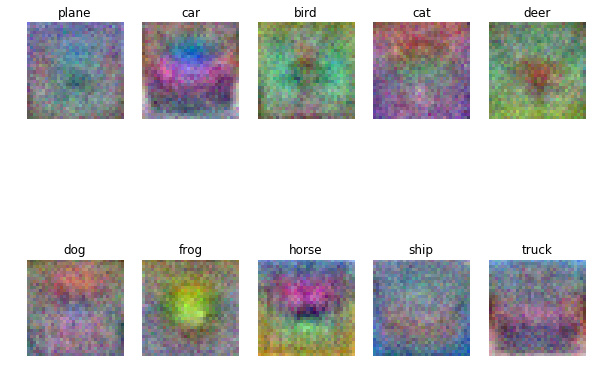

In [141]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm_regSmall.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [134]:

"""
Effect on pictures with higher regularization strength

"""

learning_rates = [1e-7, 5e-5]

#learning_rates = [ 5e-8, 1e-7, 2e-7, 5e-7]
#regularization_strengths = [ 0]
regularization_strengths = [ 1e6]


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svms = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=2000, verbose = True)
        y_val_pred = svm.predict(X_val)
        y_train_pred = svm.predict(X_train)
        val_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train == y_train_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        svms[(lr, reg)] = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_svm_regLarge = svms[(lr, reg)]
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 30749.389605
iteration 100 / 2000: loss 7.809956
iteration 200 / 2000: loss 7.552828
iteration 300 / 2000: loss 7.345076
iteration 400 / 2000: loss 7.513867
iteration 500 / 2000: loss 7.566747
iteration 600 / 2000: loss 7.386727
iteration 700 / 2000: loss 7.766818
iteration 800 / 2000: loss 7.919444
iteration 900 / 2000: loss 7.930687
iteration 1000 / 2000: loss 7.573943
iteration 1100 / 2000: loss 7.389978
iteration 1200 / 2000: loss 7.694921
iteration 1300 / 2000: loss 7.706336
iteration 1400 / 2000: loss 7.484807
iteration 1500 / 2000: loss 7.488851
iteration 1600 / 2000: loss 7.729238
iteration 1700 / 2000: loss 7.814117
iteration 1800 / 2000: loss 7.243755
iteration 1900 / 2000: loss 7.824315
iteration 0 / 2000: loss 30982.241178
iteration 100 / 2000: loss inf

/Users/arakumar/Documents/cs231/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W*W)
/Users/arakumar/Documents/cs231/assignment1/cs231n/classifiers/linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W*W)
/Users/arakumar/Documents/cs231/assignment1/cs231n/classifiers/linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W



iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.270327 val accuracy: 0.288000
lr 5.000000e-05 reg 1.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.288000


/Users/arakumar/Documents/cs231/assignment1/cs231n/classifiers/linear_svm.py:79: RuntimeWarning: invalid value encountered in maximum
  wloss =  np.maximum(0, np.transpose(np.dot(X, W)) - np.choose(y, np.transpose(np.dot(X,W))) + 1) # C X N
/Users/arakumar/Documents/cs231/assignment1/cs231n/classifiers/linear_svm.py:102: RuntimeWarning: invalid value encountered in greater
  wloss[wloss > 0] = 1


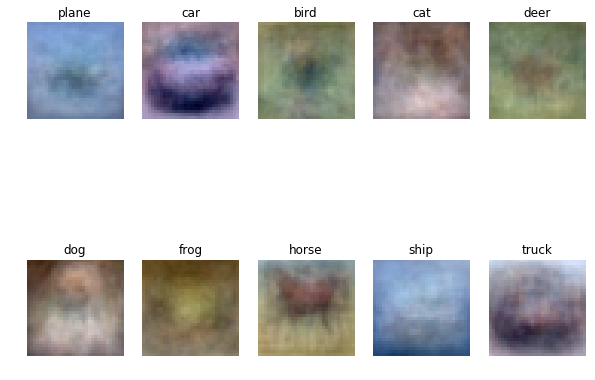

In [135]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm_regLarge.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])